<a href="https://colab.research.google.com/github/saquib9790/proj2_hci/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, random, math, itertools
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd

np.random.seed(42)
tf.random.set_seed(42)

IMG_HEIGHT, IMG_WIDTH = 64, 256
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [2]:
from huggingface_hub import snapshot_download
import zipfile

dataset_dir = snapshot_download(
  repo_id="YCAI3/HCI_P2",
  repo_type="dataset",
  local_dir="./HCI_Dataset",
  ignore_patterns=[".gitattributes"]
)

print("Dataset downloaded to:", dataset_dir)

zip_path = os.path.join(dataset_dir, "HCI_Dataset.zip")
extract_dir = os.path.join(dataset_dir, "unzipped")

# Extract the dataset if not already extracted
if not os.path.exists(extract_dir):
  with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

# Base path where the actual images live
base_path = "./HCI_Dataset/unzipped/HCI_Dataset"
assert os.path.exists(base_path), f"Expected folder not found: {base_path}"


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/971 [00:00<?, ?B/s]

HCI_Dataset.zip:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

Dataset downloaded to: /content/HCI_Dataset


In [3]:
# Recursively collect *.jpg
image_paths = glob(os.path.join(base_path, "**", "*.jpg"), recursive=True)
print("Total images found:", len(image_paths))

def get_word_label_from_filename(path):
  fname = os.path.basename(path)
  parts = fname.split("_")
  return parts[1] if len(parts) >= 2 else ""

data = pd.DataFrame({
  "path": image_paths,
  "label": [get_word_label_from_filename(p) for p in image_paths]
})

# Basic sanity check
print(data.sample(5))
print("Unique sample words:", data['label'].nunique())


Total images found: 609656
                                                     path      label
497818  ./HCI_Dataset/unzipped/HCI_Dataset/142/6/128_S...   SNORTING
180397  ./HCI_Dataset/unzipped/HCI_Dataset/16/6/250_OA...     OAXACA
232696  ./HCI_Dataset/unzipped/HCI_Dataset/80/1/368_BR...  BRITISHER
19774   ./HCI_Dataset/unzipped/HCI_Dataset/27/5/298_HO...  HOODOOING
244604  ./HCI_Dataset/unzipped/HCI_Dataset/72/6/180_Be...  Bedizened
Unique sample words: 237485


In [4]:
all_text = "".join(data["label"].astype(str).tolist())
unique_chars = sorted(list(set(all_text)))
print("Unique chars ({}):".format(len(unique_chars)), unique_chars[:80], "...")

char_to_num = layers.StringLookup(
  vocabulary=unique_chars,
  num_oov_indices=0,
  mask_token=None
)

num_to_char = layers.StringLookup(
  vocabulary=char_to_num.get_vocabulary(),
  invert=True,
  num_oov_indices=0,
  mask_token=None
)

test_word = data["label"].iloc[0]
enc = char_to_num(tf.strings.unicode_split(test_word, "UTF-8"))
dec = tf.strings.reduce_join(num_to_char(enc)).numpy().decode("utf-8")
print("Test label:", test_word, "| Encoded len:", enc.shape[0], "| Decoded:", dec)


Unique chars (62): ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] ...
Test label: undismayed | Encoded len: 10 | Decoded: undismayed


In [26]:
def preprocess_example(path, label_str):
  img_bytes = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img_bytes, channels=1)
  img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
  img = tf.cast(img, tf.float32) / 255.0

  label_chars = tf.strings.unicode_split(label_str, "UTF-8")
  label_ids = char_to_num(label_chars)

  return img, label_ids


In [6]:
idx = np.arange(len(data))
np.random.shuffle(idx)

train_end = int(0.8 * len(idx))
val_end   = int(0.9 * len(idx))

train_idx = idx[:train_end]
val_idx   = idx[train_end:val_end]
test_idx  = idx[val_end:]

train_paths = data["path"].values[train_idx]
train_labels= data["label"].values[train_idx]
val_paths   = data["path"].values[val_idx]
val_labels  = data["label"].values[val_idx]
test_paths  = data["path"].values[test_idx]
test_labels = data["label"].values[test_idx]

print("Splits -> train:", len(train_paths), "val:", len(val_paths), "test:", len(test_paths))

train_raw = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_raw   = tf.data.Dataset.from_tensor_slices((val_paths,   val_labels))
test_raw  = tf.data.Dataset.from_tensor_slices((test_paths,  test_labels))

train_mapped = train_raw.map(preprocess_example, num_parallel_calls=AUTOTUNE)
val_mapped   = val_raw.map(preprocess_example,   num_parallel_calls=AUTOTUNE)
test_mapped  = test_raw.map(preprocess_example,  num_parallel_calls=AUTOTUNE)


Splits -> train: 487724 val: 60966 test: 60966


In [7]:
def _to_dtypes(img, label_ids):
  img = tf.cast(img, tf.float32)
  label_ids = tf.cast(label_ids, tf.int32)
  return img, label_ids

train_mapped = train_mapped.map(_to_dtypes, num_parallel_calls=AUTOTUNE)
val_mapped   = val_mapped.map(_to_dtypes,   num_parallel_calls=AUTOTUNE)
test_mapped  = test_mapped.map(_to_dtypes,  num_parallel_calls=AUTOTUNE)

PADDING_VALUES = (
  tf.constant(0.0, dtype=tf.float32),
  tf.constant(-1,  dtype=tf.int32)
)

train_ds = (train_mapped.shuffle(8192, reshuffle_each_iteration=True).padded_batch(BATCH_SIZE,padded_shapes=([IMG_HEIGHT, IMG_WIDTH, 1], [None]),padding_values=PADDING_VALUES).prefetch(AUTOTUNE))

val_ds = (val_mapped.padded_batch(BATCH_SIZE,padded_shapes=([IMG_HEIGHT, IMG_WIDTH, 1], [None]),padding_values=PADDING_VALUES).prefetch(AUTOTUNE))

test_ds = (test_mapped.padded_batch(BATCH_SIZE,padded_shapes=([IMG_HEIGHT, IMG_WIDTH, 1], [None]),padding_values=PADDING_VALUES).prefetch(AUTOTUNE))

for imgs, labs in train_ds.take(1):
  print("Batch images:", imgs.shape, imgs.dtype)
  print("Batch labels shape:", labs.shape, labs.dtype)
  print("First label (padded ids):", labs[0][:20].numpy())
  break


Batch images: (32, 64, 256, 1) <dtype: 'float32'>
Batch labels shape: (32, 14) <dtype: 'int32'>
First label (padded ids): [36 38 38 40 54 54 44 50 49 54 -1 -1 -1 -1]


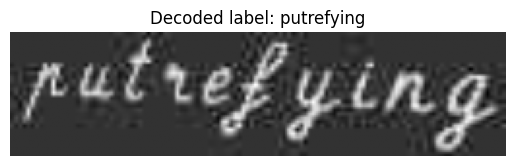

In [8]:
def decode_label_ids(label_ids_tensor):
  valid = tf.boolean_mask(label_ids_tensor, label_ids_tensor != -1)
  chars = num_to_char(valid)
  return tf.strings.reduce_join(chars).numpy().decode("utf-8")

import matplotlib.pyplot as plt

for imgs, labs in train_ds.take(1):
  idx = 0
  plt.imshow(tf.squeeze(imgs[idx]), cmap='gray')
  plt.title("Decoded label: " + decode_label_ids(labs[idx]))
  plt.axis('off')
  plt.show()
  break


In [9]:
def ctc_loss_func(y_true, y_pred):
  y_true = tf.cast(y_true, tf.int32)
  y_pred = tf.cast(y_pred, tf.float32)

  B = tf.shape(y_true)[0]
  T = tf.shape(y_pred)[1]
  label_len = tf.reduce_sum(tf.cast(y_true != -1, tf.int32), axis=1)  # (B,)

  label_len = tf.minimum(label_len, T)

  y_true_fixed = tf.where(y_true < 0, tf.zeros_like(y_true), y_true)

  input_len = tf.fill([B, 1], T)
  label_len = tf.reshape(label_len, [B, 1])

  return tf.keras.backend.ctc_batch_cost(y_true_fixed, y_pred, input_len, label_len)


In [10]:
from tensorflow.keras import layers, models

def build_crnn_lstm(img_h=IMG_HEIGHT, img_w=IMG_WIDTH, vocab_size=None):
  assert vocab_size is not None, "Pass vocab_size=len(unique_chars)+1 (for CTC blank)."

  inp = layers.Input(shape=(img_h, img_w, 1), name="image")

  x = layers.random.RandomFlip("vertical")(inp)
  x = layers.random.RandomInvert(factor=1.0, value_range=(0, 255), seed=None, data_format=None)
  x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(inp)
  x = layers.MaxPooling2D((2,2))(x)

  x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
  x = layers.MaxPooling2D((2,2))(x)

  x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.2)(x)

  Hp = img_h // 8
  Wp = img_w // 8
  C  = 128

  x = layers.Permute((2, 1, 3))(x)
  x = layers.Reshape((Wp, Hp * C))(x)

  x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
  x = layers.Bidirectional(layers.LSTM(64,  return_sequences=True))(x)

  out = layers.Dense(vocab_size, activation="softmax")(x)

  return models.Model(inputs=inp, outputs=out, name="CRNN_LSTM")

VOCAB_SIZE = len(unique_chars) + 1
crnn_lstm = build_crnn_lstm(vocab_size=VOCAB_SIZE)

crnn_lstm.summary()


Model: "CRNN_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 256, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 256, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute (Permute)               │ (None, 32, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32, 256)        │     1,180,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32, 63)         │         8,127 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,575,231 (6.01 MB)

 Trainable params: 1,575,231 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Peek at one batch
imgs, labs = next(iter(train_ds))
print("Batch images:", imgs.shape, imgs.dtype)
print("Batch labels:", labs.shape, labs.dtype)

probe = crnn_lstm(imgs[:1])
print("Model output shape (B, T, C):", probe.shape)


Batch images: (32, 64, 256, 1) <dtype: 'float32'>
Batch labels: (32, 17) <dtype: 'int32'>
Model output shape (B, T, C): (1, 32, 63)


In [21]:
SUB_TRAIN = 60000
SUB_VAL   = 12000

subset_train = (
  train_ds
  .unbatch()
  .take(SUB_TRAIN)
  .batch(BATCH_SIZE)
  .repeat()
  .prefetch(tf.data.AUTOTUNE)
)
subset_val = (
  val_ds
  .unbatch()
  .take(SUB_VAL)
  .batch(BATCH_SIZE)
  .repeat()
  .prefetch(tf.data.AUTOTUNE)
)

steps_per_epoch  = (SUB_TRAIN + BATCH_SIZE - 1) // BATCH_SIZE
validation_steps = (SUB_VAL   + BATCH_SIZE - 1) // BATCH_SIZE

crnn_lstm.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
  loss=ctc_loss_func
)

callbacks = [
  keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
  keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
]

history_lstm_adam = crnn_lstm.fit(
  subset_train,
  validation_data=subset_val,
  epochs=20,
  steps_per_epoch=steps_per_epoch,
  validation_steps=validation_steps,
  verbose=1
)


Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 69s 34ms/step - loss: 10.0499 - val_loss: 9.2730
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 63s 34ms/step - loss: 9.0808 - val_loss: 8.4657
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 63s 34ms/step - loss: 8.3150 - val_loss: 7.8679
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 63s 34ms/step - loss: 7.7097 - val_loss: 7.4059
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 63s 34ms/step - loss: 7.1522 - val_loss: 7.0039
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 63s 34ms/step - loss: 6.7575 - val_loss: 6.8546
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 64s 34ms/step - loss: 6.4514 - val_loss: 6.4332
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 63s 34ms/step - loss: 6.0284 - val_loss: 6.2056
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 63s 33ms/step - loss: 5.7687 - val_loss: 6.0692
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 62s 33ms/step - loss: 5.5272 - val_loss: 5.8361
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 62s 33ms/step - loss: 5.2509 - val_loss: 5.6826
Epoch 1

In [22]:
best_val = min(history_lstm_adam.history['val_loss'])
print(f"Best val_loss: {best_val:.4f}")


Best val_loss: 4.9126


In [23]:
import json

crnn_lstm.save("crnn_lstm_adam.keras")

with open("vocab.json", "w") as f:
  json.dump(unique_chars, f)

with open ("history_lstm_adam.json", "w") as f:
  json.dump(history_lstm_adam.history, f)


In [15]:
import json

with open("vocab.json", "r") as f:
  vocab = json.load(f)

char_to_num = layers.StringLookup(
  vocabulary=vocab,
  num_oov_indices=0,
  mask_token=None
)
num_to_char = layers.StringLookup(
  vocabulary=char_to_num.get_vocabulary(),
  invert=True,
  num_oov_indices=0,
  mask_token=None
)
# The CTC blank is the last index by construction (len(vocab))
blank_index = len(vocab)

inference_model = keras.models.load_model("crnn_lstm_adam.keras", compile=False)

In [18]:
from google.colab import files

print("Please upload the video file you want to process:")
uploaded = files.upload()

for filename in uploaded.keys():
    print(f'User uploaded file "{filename}"')
    # You can now use 'filename' to refer to the uploaded file,
    # for example, by setting input_video_path = filename in the next cell.

Please upload the video file you want to process:


KeyboardInterrupt: 

In [24]:
# === Ultra-minimal CRNN video recognizer (one decode per frame, with small QoL tweaks) ===
import os, json, itertools
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- paths (edit if needed) ---
MODEL_PATH   = "crnn_lstm_adam.keras"   # your Task 1 CRNN
VOCAB_PATH   = "vocab.json"             # saved list of chars (no blank)
INPUT_VIDEO  = "my_test_video.mp4"
OUTPUT_VIDEO = "output_video_adam.mp4"

# --- must match training ---
IMG_HEIGHT, IMG_WIDTH = 64, 256

# --- small runtime knobs ---
BAND_FRAC     = 0.32 # taller center band (0.33 -> 0.45)
FRAME_STRIDE  = 2     # set to 2 or 3 to process every Nth frame

# --- load model + vocab + lookups ---
model = keras.models.load_model(MODEL_PATH, compile=False)
with open(VOCAB_PATH, "r") as f:
    unique_chars = json.load(f)

char_to_num = layers.StringLookup(vocabulary=unique_chars, num_oov_indices=0, mask_token=None)
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), invert=True,
                                  num_oov_indices=0, mask_token=None)
BLANK = len(unique_chars)  # CTC blank is vocab+1

print(f"Loaded model: {model.name} | vocab={len(unique_chars)} | blank={BLANK}")

# --- Greedy CTC decoder (argmax -> collapse repeats -> drop blanks) ---
def greedy_decode(y_pred, blank_index=BLANK):
    idx = np.argmax(y_pred[0], axis=-1)                  # (T,)
    collapsed = [k for k, _ in itertools.groupby(idx)]   # remove repeats
    kept = [i for i in collapsed if i != blank_index]    # remove blanks
    if not kept:
        return ""
    chars = num_to_char(tf.constant(kept))
    return tf.strings.reduce_join(chars).numpy().decode("utf-8")

# --- fixed-band crop: central horizontal strip ---
def crop_center_band(gray, band_frac=BAND_FRAC):
    H, W = gray.shape
    band_h = max(30, int(H * band_frac))
    y0 = (H - band_h) // 2
    return gray[y0:y0+band_h, :], (0, y0, W, band_h)

# --- preprocess to match training (grayscale already) ---
def to_batch(img_gray):
    # Keep dark text on light bg: invert if crop is very dark overall
    if img_gray.mean() < 115:
        img_gray = cv2.bitwise_not(img_gray)
    img = cv2.resize(img_gray, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LINEAR)
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, -1)      # (H, W, 1)
    return np.expand_dims(img, 0)      # (1, H, W, 1)

# --- video I/O ---
cap = cv2.VideoCapture(INPUT_VIDEO)
if not cap.isOpened():
    raise RuntimeError(f"Cannot open {INPUT_VIDEO}")

W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS) or 24
writer = cv2.VideoWriter(OUTPUT_VIDEO, cv2.VideoWriter_fourcc(*"mp4v"), fps, (W, H))

print(f"Processing {INPUT_VIDEO} → {OUTPUT_VIDEO} ...")

last_text = ""      # temporal smoothing: persist last non-empty prediction
frame_idx = 0

while True:
    ok, frame = cap.read()
    if not ok:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    band, (x,y,w,h) = crop_center_band(gray, band_frac=BAND_FRAC)

    # Inference every Nth frame; reuse last_text otherwise
    if frame_idx % FRAME_STRIDE == 0:
        batch = to_batch(band)
        y_pred = model.predict(batch, verbose=0)     # (1, T, C)
        text = greedy_decode(y_pred, blank_index=BLANK)
        if text:                                     # update only on non-empty
            last_text = text

    # Draw ONE overlay (rectangle + single line of text)
    cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2)
    cv2.putText(frame, last_text if last_text else "(…)", (max(10, x+10), max(40, y-12)),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,255,0), 2, cv2.LINE_AA)

    writer.write(frame)
    frame_idx += 1

cap.release()
writer.release()
print("✅ Saved:", OUTPUT_VIDEO)


Loaded model: CRNN_LSTM | vocab=62 | blank=62
Processing my_test_video.mp4 → output_video_adam.mp4 ...
✅ Saved: output_video_adam.mp4
